In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms as T
from torch.utils import data

In [3]:
from tqdm import tqdm
import os, time, sys
import json

In [4]:
import dtnnlib as dtnn
# import resnet_cifar

In [5]:
mnist_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=0.5,
        std=0.5,
    ),
])

# train_dataset = datasets.FashionMNIST(root="../../../_Datasets/", train=True, download=True, transform=mnist_transform)
# test_dataset = datasets.FashionMNIST(root="../../../_Datasets/", train=False, download=True, transform=mnist_transform)
train_dataset = datasets.MNIST(root="../../../_Datasets/", train=True, download=True, transform=mnist_transform)
test_dataset = datasets.MNIST(root="../../../_Datasets/", train=False, download=True, transform=mnist_transform)

In [6]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [7]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

In [8]:
device = torch.device("cpu")

In [9]:
for xx, yy in train_loader:
    print(xx.shape)
    xx, yy = xx.view(-1,28*28).to(device), yy.to(device)
    print(xx.shape, yy.shape)
    break

torch.Size([50, 1, 28, 28])
torch.Size([50, 784]) torch.Size([50])


## Train Test method

In [10]:
criterion = nn.CrossEntropyLoss()

In [11]:
## Following is copied from 
### https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

# Training
def train(epoch, model, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device).view(-1, 28*28), targets.to(device)
        
        ### Train with random image and "10" as class
#         inputs = torch.cat([inputs, torch.rand(batch_size//10, 28*28, dtype=inputs.dtype).to(device)*2-1], dim=0)
#         targets = torch.cat([targets, torch.ones(batch_size//10, dtype=targets.dtype).to(device)*10], dim=0)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    print(f"[Train] {epoch} Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    return

In [12]:
best_acc = -1
def test(epoch, model, model_name, save=False):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
            inputs, targets = inputs.to(device).view(-1, 28*28), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    print(f"[Test] {epoch} Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if save:
            if not os.path.isdir('models'):
                os.mkdir('models')
            torch.save(state, f'./models/{model_name}.pth')
        best_acc = acc

## Models

In [13]:
class DistanceTransform_Epsilon(dtnn.DistanceTransformBase):
    
    def __init__(self, input_dim, num_centers, p=2, bias=False, epsilon=0.1):
        super().__init__(input_dim, num_centers, p=2)
        
        nc = num_centers
        if epsilon is not None:
            nc += 1
        self.scaler = nn.Parameter(torch.log(torch.ones(1, 1)*1))
#         self.scaler = nn.Parameter(torch.log(torch.ones(1, nc)*1))
        self.bias = nn.Parameter(torch.ones(1, nc)*0) if bias else None
        self.epsilon = epsilon
        
    def forward(self, x):
        dists = super().forward(x)
        
        if self.epsilon is not None:
            dists = torch.cat([dists, torch.ones(len(x), 1, dtype=x.dtype)*self.epsilon], dim=1)
        
        ### normalize similar to UMAP
        dists = dists/torch.sqrt(dists.var(dim=1, keepdim=True)+1e-9)
        
        ## scale the dists
#         dists = torch.exp(-dists.abs()+self.scaler)
        dists = 1-dists*torch.exp(self.scaler)
    
        if self.bias is not None: dists = dists+self.bias
        return dists

In [14]:
class LocalMLP_epsilonsoftmax(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, epsilon=1.0):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.new_hidden_dim = 0
        self.output_dim = output_dim
        
        self.layer0 = DistanceTransform_Epsilon(self.input_dim, self.hidden_dim, bias=True, epsilon=epsilon)
        hdim = self.hidden_dim
        if epsilon is not None:
            hdim += 1
            
        self.scale_shift = dtnn.ScaleShift(hdim, scaler_init=3, shifter_init=0, scaler_const=True, shifter_const=True)
        self.softmax = nn.Softmax(dim=-1)
#         self.softmax = F.gumbel_softmax

#         self.activ = dtnn.OneActiv(hdim, mode='exp_1.6', beta_init=np.log(2))
        self.activ = dtnn.OneActiv(hdim, mode='relu', beta_init=np.log(1.2))
#         self.activ = nn.ReLU()

        self.layer1 = nn.Linear(hdim, self.output_dim)
    
        self.temp_maximum = None
        
    def forward(self, x):
        xo = self.layer0(x)
        ## dropout here creates 0 actv (is relatively high), hence serves as noise --> does not work for high values
#         xo = F.dropout(xo, p=0.001, training=self.training)
        xo = self.scale_shift(xo)
        xo = self.softmax(xo)
        self.temp_maximum = xo.data
        
        ## drouout here is suitable for activation function (the probabilities do not add upto 1)
#         xo = F.dropout(xo, p=0.1, training=self.training)
        
        ### This feature is useful when the softmax has uniform and low probability
#         xo = xo/xo.max(dim=1, keepdim=True)[0].detach() ## produces poor decision boundary 
        
#         rejected = torch.count_nonzero(xo.argmax(dim=1) == self.hidden_dim) 
        xo = self.activ(xo)
        xo = self.layer1(xo)
        return xo

In [15]:
H = 100

model = LocalMLP_epsilonsoftmax(784, H, 11, epsilon=9.0)
model_name = "epsilonSM_MLP_ep9"

# model = LocalMLP_epsilonsoftmax(784, H, 11, epsilon=None)
# model_name = "epsilonSM_MLP_epNone"

model

LocalMLP_epsilonsoftmax(
  (layer0): DistanceTransform_Epsilon()
  (scale_shift): ScaleShift()
  (softmax): Softmax(dim=-1)
  (activ): OneActiv()
  (layer1): Linear(in_features=101, out_features=11, bias=True)
)

In [16]:
model(xx).shape

torch.Size([50, 11])

In [17]:
model.training

True

In [18]:
idx = torch.randperm(len(train_loader.dataset))[:H]
source, target = train_dataset.data[idx].reshape(-1, 784), train_dataset.targets[idx]
source.shape, target.shape

(torch.Size([100, 784]), torch.Size([100]))

In [19]:
model.layer0.centers.data = source.type(torch.float32)/128-1

In [20]:
targets = torch.zeros(len(target), 11)
for i, t in enumerate(target):
    targets[i, t] = 1.
    targets[i,-1] = 0.05

if model.layer0.epsilon is not None:
    e = torch.zeros(1, 11)
    e[0,-1] = 1.
    targets = torch.cat([targets, e], dim=0)

targets.shape
# targets[-1]

torch.Size([101, 11])

In [21]:
model.layer1.weight.data = targets.t()#.to(device)

In [22]:
def forward_intermediate(self, x):
    xo = self.layer0(x)
    xo = self.scale_shift(xo)
    xo = self.softmax(xo).data
    print(xo.shape)
    print(xo.mean(dim=0), "\n ", xo.std(dim=0))
    print(xo.min(dim=0)[0], "\n ", xo.max(dim=0)[0])

forward_intermediate(model, xx)

torch.Size([50, 101])
tensor([1.5739e-06, 2.2190e-06, 9.0653e-06, 2.4668e-05, 8.0358e-03, 2.0359e-03,
        2.7931e-05, 5.6393e-05, 6.1231e-04, 1.5053e-03, 4.3746e-05, 1.0767e-04,
        6.1066e-04, 9.8150e-05, 5.1573e-06, 1.0070e-03, 2.1627e-06, 5.9363e-05,
        3.7299e-05, 1.5933e-03, 1.0251e-06, 1.6904e-04, 2.3683e-04, 4.2808e-04,
        6.1560e-05, 2.9480e-07, 3.2767e-05, 3.1424e-04, 1.1855e-05, 1.2512e-04,
        8.6492e-04, 2.2078e-06, 1.2403e-05, 6.8912e-07, 4.1832e-05, 1.8241e-06,
        7.2580e-05, 1.2302e-04, 6.2159e-04, 8.9107e-04, 1.0351e-04, 3.9141e-06,
        6.4024e-04, 1.2550e-04, 8.9008e-05, 9.1594e-07, 6.6941e-04, 3.5072e-04,
        7.9431e-04, 4.6513e-04, 5.4937e-05, 2.4424e-05, 1.8169e-03, 6.4663e-04,
        2.6295e-04, 2.9387e-04, 5.0713e-04, 1.6177e-04, 1.5706e-05, 5.1372e-04,
        4.6675e-03, 8.9550e-05, 5.8316e-07, 1.6971e-05, 4.2809e-06, 1.4887e-04,
        9.4602e-07, 7.7095e-06, 3.6033e-06, 9.9900e-04, 9.5710e-04, 3.7018e-05,
        2.8365e-06

In [23]:
test(-1, model, model_name="", save=False)

100%|██████████| 200/200 [00:01<00:00, 163.87it/s]

[Test] -1 Loss: 2.470 | Acc: 9.140 914/10000
Saving..


## Model Training

In [24]:
learning_rate = 0.01
"""
Use Small LR for centers and larger for rest (center deviated too much)
"""

EPOCHS = 15

In [25]:
### https://stackoverflow.com/questions/51801648/how-to-apply-layer-wise-learning-rate-in-pytorch
p1, p2 = [], []
for p in model.named_parameters():
    if p[0] == "layer0.centers":
        p1.append(p[1])
    else:
        p2.append(p[1])

params = [
    {"params": p1, "lr": 3e-4}, ## default - to change little from data point
#     {"params": p1},
    {"params": p2},
]

In [26]:
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

optimizer = torch.optim.Adam(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

best_acc = -1
for epoch in range(EPOCHS):
    train(epoch, model, optimizer)
    test(epoch, model, model_name, save=False)
    scheduler.step()

100%|██████████| 1200/1200 [00:12<00:00, 96.22it/s]


[Train] 0 Loss: 0.842 | Acc: 74.532 44719/60000


100%|██████████| 200/200 [00:02<00:00, 90.95it/s] 


[Test] 0 Loss: 0.555 | Acc: 82.020 8202/10000
Saving..


100%|██████████| 1200/1200 [00:13<00:00, 87.48it/s]


[Train] 1 Loss: 0.503 | Acc: 83.655 50193/60000


100%|██████████| 200/200 [00:02<00:00, 85.01it/s]


[Test] 1 Loss: 0.516 | Acc: 82.610 8261/10000
Saving..


100%|██████████| 1200/1200 [00:14<00:00, 85.08it/s] 


[Train] 2 Loss: 0.431 | Acc: 85.943 51566/60000


100%|██████████| 200/200 [00:01<00:00, 114.00it/s]


[Test] 2 Loss: 0.401 | Acc: 87.360 8736/10000
Saving..


100%|██████████| 1200/1200 [00:16<00:00, 72.67it/s]


[Train] 3 Loss: 0.385 | Acc: 87.612 52567/60000


100%|██████████| 200/200 [00:02<00:00, 91.68it/s] 


[Test] 3 Loss: 0.365 | Acc: 88.340 8834/10000
Saving..


100%|██████████| 1200/1200 [00:22<00:00, 52.52it/s] 


[Train] 4 Loss: 0.351 | Acc: 88.825 53295/60000


100%|██████████| 200/200 [00:01<00:00, 111.84it/s]


[Test] 4 Loss: 0.345 | Acc: 89.140 8914/10000
Saving..


100%|██████████| 1200/1200 [00:13<00:00, 91.57it/s] 


[Train] 5 Loss: 0.322 | Acc: 89.840 53904/60000


100%|██████████| 200/200 [00:01<00:00, 122.42it/s]


[Test] 5 Loss: 0.318 | Acc: 89.970 8997/10000
Saving..


100%|██████████| 1200/1200 [00:12<00:00, 93.18it/s] 


[Train] 6 Loss: 0.302 | Acc: 90.552 54331/60000


100%|██████████| 200/200 [00:01<00:00, 120.28it/s]


[Test] 6 Loss: 0.299 | Acc: 90.700 9070/10000
Saving..


100%|██████████| 1200/1200 [00:11<00:00, 101.93it/s]


[Train] 7 Loss: 0.287 | Acc: 91.060 54636/60000


100%|██████████| 200/200 [00:01<00:00, 138.94it/s]


[Test] 7 Loss: 0.303 | Acc: 90.950 9095/10000
Saving..


100%|██████████| 1200/1200 [00:10<00:00, 115.71it/s]


[Train] 8 Loss: 0.274 | Acc: 91.503 54902/60000


100%|██████████| 200/200 [00:01<00:00, 145.20it/s]


[Test] 8 Loss: 0.279 | Acc: 91.210 9121/10000
Saving..


100%|██████████| 1200/1200 [00:10<00:00, 111.53it/s]


[Train] 9 Loss: 0.265 | Acc: 91.733 55040/60000


100%|██████████| 200/200 [00:01<00:00, 146.26it/s]


[Test] 9 Loss: 0.269 | Acc: 91.760 9176/10000
Saving..


100%|██████████| 1200/1200 [00:10<00:00, 109.17it/s]


[Train] 10 Loss: 0.256 | Acc: 92.033 55220/60000


100%|██████████| 200/200 [00:01<00:00, 107.84it/s]


[Test] 10 Loss: 0.262 | Acc: 91.800 9180/10000
Saving..


100%|██████████| 1200/1200 [00:11<00:00, 106.16it/s]


[Train] 11 Loss: 0.251 | Acc: 92.278 55367/60000


100%|██████████| 200/200 [00:01<00:00, 127.62it/s]


[Test] 11 Loss: 0.256 | Acc: 91.920 9192/10000
Saving..


100%|██████████| 1200/1200 [00:12<00:00, 96.82it/s] 


[Train] 12 Loss: 0.246 | Acc: 92.387 55432/60000


100%|██████████| 200/200 [00:01<00:00, 141.73it/s]


[Test] 12 Loss: 0.254 | Acc: 92.040 9204/10000
Saving..


100%|██████████| 1200/1200 [00:10<00:00, 111.75it/s]


[Train] 13 Loss: 0.244 | Acc: 92.520 55512/60000


100%|██████████| 200/200 [00:01<00:00, 134.73it/s]


[Test] 13 Loss: 0.252 | Acc: 92.020 9202/10000


100%|██████████| 1200/1200 [00:11<00:00, 108.06it/s]


[Train] 14 Loss: 0.242 | Acc: 92.522 55513/60000


100%|██████████| 200/200 [00:01<00:00, 141.92it/s]

[Test] 14 Loss: 0.251 | Acc: 92.020 9202/10000


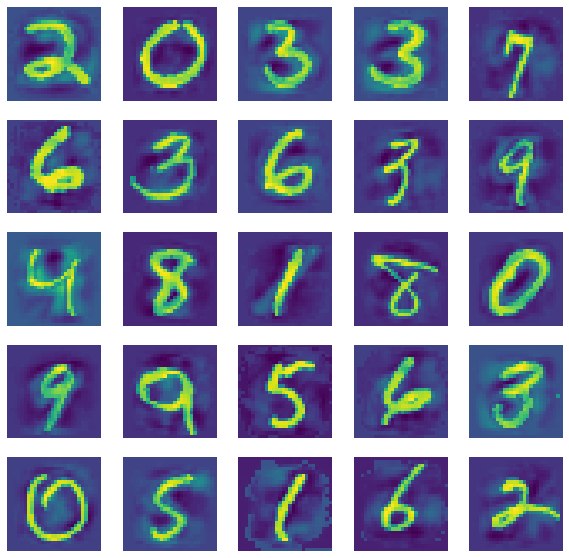

In [27]:
_, axs = plt.subplots(5, 5, figsize=(10, 10))
axs = axs.flatten()

c = model.layer0.centers.data.cpu().numpy().reshape(-1, 28,28)
imgs = c[:len(axs)]

for img, ax in zip(imgs, axs):
    ax.imshow(img)
    ax.set_axis_off()

plt.show()

#### Test for random image sample

In [28]:
with torch.no_grad():
    inputs = torch.rand(10, 28*28).to(device)*2-1
    xo = model.layer0(inputs)
    xo = model.scale_shift(xo)
    xo = model.softmax(xo).data

In [29]:
# xo.argmax(dim=1)
xo.max(dim=1)

torch.return_types.max(values=tensor([0.9891, 0.9883, 0.9884, 0.9877, 0.9896, 0.9873, 0.9908, 0.9833, 0.9923,
        0.9869]), indices=tensor([100, 100, 100, 100, 100, 100, 100, 100, 100, 100]))

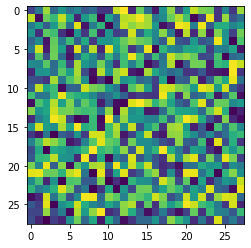

In [30]:
j=0
plt.imshow(inputs[j].reshape(28,28))

In [31]:
i = -1
nearest = torch.argsort(xo[j], descending=True)
nearest

tensor([100,   0,  35,  76,  79,   3,  51,  41,  90,  62,  93,   2,   7,  19,
         68,  48,  14,  59,   1,  27,  91,  75,  39,  21,  26,  10,  34,  85,
         86,  37,  81,  82,  30,  11,  98,  36,  46,  89,  38,  15,   9,  63,
         12,  42,  56,  74,  72,  13,  31,  53,   8,  71,  88,  17,   5,  83,
         66,  33,  77,  50,  45,   6,  16,  95,  43,  58,  40,  60,  18,  94,
          4,  29,  61,  28,  73,  57,  52,  80,  23,  87,  99,  20,  69,  32,
         97,  84,  55,  96,  47,  44,  54,  24,  78,  92,  64,  22,  67,  65,
         70,  25,  49])

In [32]:
xo.shape

torch.Size([10, 101])

In [33]:
i+=1
print("prob:", xo[0][nearest[i]])
try:
    plt.imshow(model.layer0.centers.data[nearest[i]].reshape(28,28))
except:
    pass

prob: tensor(0.9891)


In [34]:
with torch.no_grad():
    xo_ = model.activ(xo)
    xo_ = model.layer1(xo_).data

In [35]:
xo_.argmax(dim=1)

tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8])

In [36]:
#  model.layer1.weight[1], model.layer1.weight[10]

In [37]:
## scaling of softmax activation
torch.exp(model.activ.beta)

tensor([[1.0118, 1.0024, 1.0024, 1.0019, 1.0293, 1.0299, 1.3137, 0.9940, 1.0822,
         1.0032, 0.9961, 0.9845, 1.0055, 1.0203, 0.9992, 0.9991, 1.2925, 1.0120,
         1.2534, 1.0055, 1.2691, 1.0009, 1.1665, 1.1518, 1.1395, 1.2449, 1.0030,
         1.0003, 1.0053, 1.0659, 1.0042, 0.9731, 1.0993, 1.0403, 1.0011, 1.0045,
         0.9979, 0.9993, 1.0134, 1.0055, 1.0312, 0.9988, 0.9996, 1.1636, 1.0628,
         1.1243, 0.9999, 1.2514, 1.0026, 1.0231, 1.0175, 1.0021, 1.0496, 1.0408,
         1.0176, 1.0481, 1.0003, 1.1605, 1.3302, 1.0006, 1.0659, 1.3023, 1.0045,
         1.0076, 1.1962, 1.2423, 1.0130, 1.0512, 0.9738, 1.0400, 1.0578, 1.0398,
         1.0097, 1.0755, 1.0287, 0.9987, 0.9976, 1.0768, 1.0057, 1.0150, 1.2109,
         1.0106, 1.0007, 1.0700, 1.0521, 0.9982, 1.0042, 1.0144, 1.0168, 1.0066,
         1.0005, 1.0017, 1.1313, 1.0007, 1.0888, 1.1736, 1.0167, 1.0140, 1.0006,
         1.4677, 0.9970]], grad_fn=<ExpBackward>)

In [38]:
imgs.min(), imgs.max()

(-1.889351, 1.7032309)

In [39]:
model.layer1.weight.data[:,5]

tensor([-0.0069, -0.2045, -0.0481, -0.1688, -0.0592, -0.1050,  0.7883, -0.2865,
        -0.1673, -0.1406, -2.8189])

## Adverserial Test

In [40]:
import foolbox as fb
import foolbox.attacks as fa

In [41]:
fmodel = fb.PyTorchModel(model.eval(), bounds=(-1, 1), device=device)

# attack = fa.LinfPGD()
attack = fa.FGSM()
# epsilons = [0.0, 0.001, 0.01, 0.03, 0.1, 0.3, 0.5, 1.0]

In [51]:
count = 0
failed = 0
rejected = 0
x_rejected = 0
for i, (xx, yy) in enumerate(tqdm(test_loader)):
    xx = xx.reshape(-1, 28*28)
    
    yout = model(xx)
    reject_out = yout.argmax(dim=1) == 10
    reject_hid = model.temp_maximum.max(dim=1)[1] == model.hidden_dim
    reject = torch.bitwise_or(reject_out, reject_hid)
    x_rejected += int(reject.type(torch.float32).sum())
    
    _, advs, success = attack(fmodel, xx, yy, epsilons=0.5)   
    yout = model(advs)
    reject_out = yout.argmax(dim=1) == 10
    reject_hid = model.temp_maximum.max(dim=1)[1] == model.hidden_dim
    reject = torch.bitwise_or(reject_out, reject_hid)
#     reject = reject_out
    rejected += int(reject.type(torch.float32).sum())
    
    fail = torch.bitwise_and(success, ~reject).type(torch.float32).sum()
#     fail = success.type(torch.float32).sum()
    failed += int(fail)    
    count += len(xx)

#     break

100%|██████████| 200/200 [00:02<00:00, 88.36it/s] 


In [52]:
# success

In [53]:
count, failed, rejected, x_rejected

(10000, 4079, 5156, 634)

In [54]:
(failed+x_rejected)/count

0.4713

In [46]:
# model.temp_maximum.max(dim=1)[1]

In [47]:
# yout.argmax(dim=1)

In [50]:
model.layer0.epsilon = 5.0

In [49]:
"""
- epsilon can be changed to reject more and more inputs (including adverserial)
- Create Epsilon_hull and find how much test data lie inside
- Related works: https://arxiv.org/pdf/2010.09119.pdf (this uses different subnetwork for classification and uncertainity estimation)


- Changing centers away from data-samples reduces rejections!
"""

'\n- epsilon can be changed to reject more and more inputs (including adverserial)\n- Create Epsilon_hull and find how much test data lie inside\n- Related works: https://arxiv.org/pdf/2010.09119.pdf (this uses different subnetwork for classification and uncertainity estimation)\n\n\n- Changing centers away from data-samples reduces rejections!\n'